In [62]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(rc={'figure.figsize':(20,15),"font.size":20,"axes.titlesize":20,"axes.labelsize":20})

from timeit import default_timer as timer
import math
from decimal import Decimal

from IPython.display import display

import scipy.optimize as opt
from scipy import spatial

import frigidum

from frigidum.examples import tsp

In [18]:
#A counter class accepts callback function
class Counter:
    def __init__(self,cb):
        self.counter=0
        self.callback=cb

    def __call__(self, *args):
        self.counter+=1
        return self.callback(*args)

    def value(self):
        return self.counter
    
    def reset(self):
        self.counter=0

In [19]:
#random numbers with noise 
def original_func(x):
    return 1 / (x**2 - 3*x + 2)

np.random.seed(6913678)

#1001 numbers
x = np.linspace(0, 3, 1001)
print(x[0:10])

#1001 samples from the “standard normal” distribution
deltak = np.random.randn(1001)
print(deltak)

yk_original=original_func(x)
yk_original[yk_original<-100]=-100
yk_original[yk_original>100]=100


yk = yk_original + deltak

yk

[0.    0.003 0.006 0.009 0.012 0.015 0.018 0.021 0.024 0.027]
[-0.96787436  1.58294477 -0.13160214 ...  1.07695424  1.10976223
 -0.33568246]


array([-0.46787436,  2.08520267,  0.37292956, ...,  1.58148594,
        1.61202013,  0.16431754])

<AxesSubplot:>

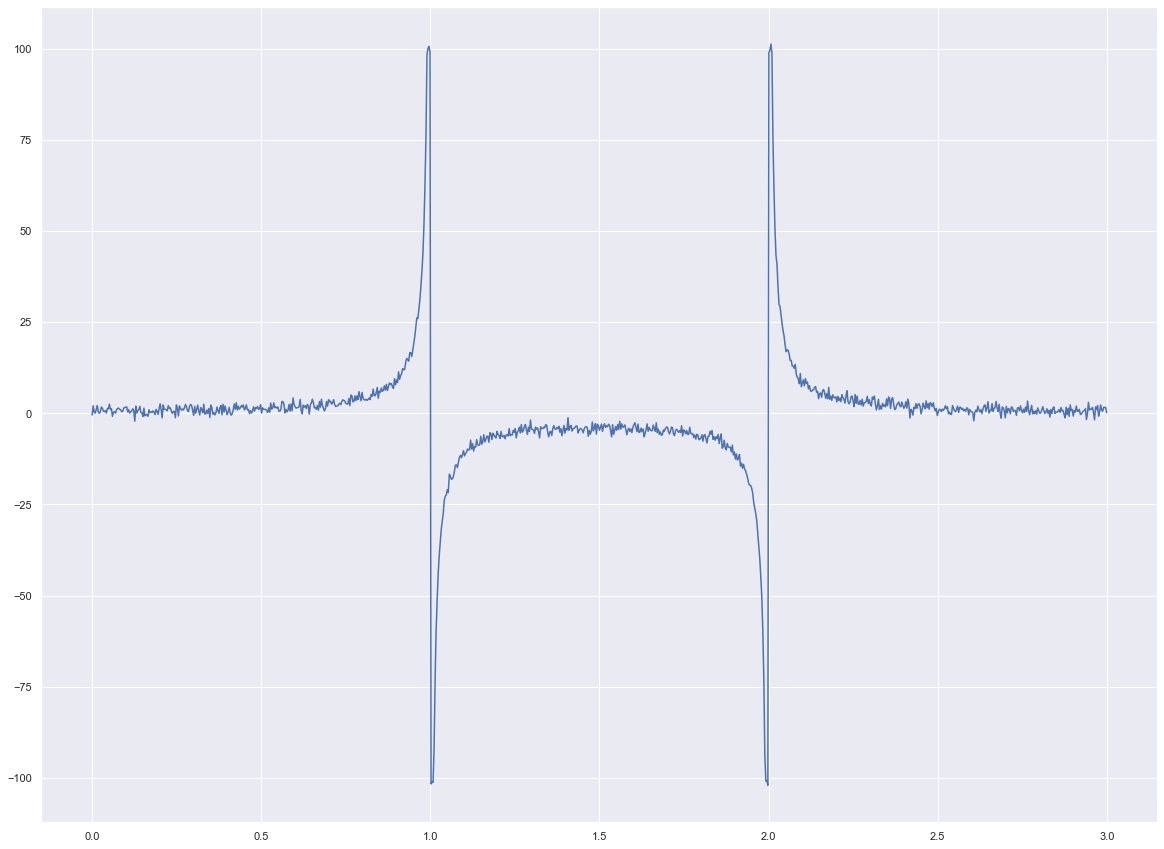

In [20]:
sns.lineplot(y=yk,x=x)

In [27]:
def rationalSingle(x, a, b, c, d):
    return (a*x + b) / (x**2 + c * x + d)

def rational(x, a, b, c, d):
    return list(map(lambda x:rationalSingle(x, a, b, c, d),x))

def sum_squares(params, y, x, f):
    return sum((y - f(x, *params))**2)

#vector of difference
def diff(params, y, x, f):

    
    return y - f(x,*params)

def derivative(f,k,prec):
    return (f(k+prec)-f(k))/prec

#derivative(lambda a:linearSingle(1,a,1),1,0.001)

In [22]:
prec=0.001

In [53]:
#a, b, c, d by Levenberg-Marquardt with rational aprox (contains in x prop)
#Counter value (real) and nfev are the same for another methods
LM_c=Counter(rational)
#We will find the number of iterations if we use counter for diff function
diff_c=Counter(diff)
rationalLevenbergMarquardt = opt.least_squares(diff_c, x0=[1, 1, 1, 1], args=(yk, x, LM_c), xtol=prec, method='lm')

#a, b, c, d by Nelder-Mead with rational aprox (contains in x prop)
rationalNelderMead = opt.minimize(sum_squares, x0=[1, 1, 1, 1], args=(yk, x, rational), tol=prec, method='Nelder-Mead')

#a, b, c, d by Annealing with rational aprox (contains in x prop) 
rationalAnnealing2000 = opt.dual_annealing(sum_squares,seed=45258,maxiter=1000, x0=[1, 1, 1, 1],bounds=((-5, 5), (-5, 5), (-5, 5), (-5, 5)),initial_temp=2000, args=(yk, x, rational))
#rationalAnnealing6000 = opt.dual_annealing(sum_squares,maxiter=1000, x0=[1, 1, 1, 1],bounds=((-5, 5), (-5, 5), (-5, 5), (-5, 5)),initial_temp=6000, args=(yk, x, rational))

#a, b, c, d by Differential evolution with rational aprox (contains in x prop) 
rationalDE=opt.differential_evolution(sum_squares,seed=1124868,maxiter=1000,bounds=((-5, 5), (-5, 5), (-5, 5), (-5, 5)), args=(yk, x, rational), tol=prec)

print("Levenberg-Marquardt: ",rationalLevenbergMarquardt.x)
print("Nelder-Mead: ",rationalNelderMead.x)
print("Annealing2000: ",rationalAnnealing2000.x)
#print("Annealing6000: ",rationalAnnealing6000.x)
print("Differential evolution: ",rationalDE.x)

print("Levenberg-Marquardt: nit:",diff_c.value(),"   nfev: ",LM_c.value())
print("Nelder-Mead: nit:",rationalNelderMead.nit,"   nfev: ",rationalNelderMead.nfev)
print("Annealing2000: nit:",rationalAnnealing2000.nit,"   nfev: ",rationalAnnealing2000.nfev)
#print("Annealing6000: nit:",rationalAnnealing6000.nit,"   nfev: ",rationalAnnealing6000.nfev)
print("Differential evolution: nit:",rationalDE.nit,"   nfev: ",rationalDE.nfev)

Levenberg-Marquardt:  [-1.00756958  1.00803221 -2.00088489  1.00090107]
Nelder-Mead:  [-1.00332318  1.00379432 -2.00093524  1.00095128]
Annealing2000:  [-1.00320191  1.00367313 -2.00093554  1.00095157]
Differential evolution:  [-1.00486157  1.0053418  -2.00094107  1.00095716]
Levenberg-Marquardt: nit: 134    nfev:  134
Nelder-Mead: nit: 444    nfev:  740
Annealing2000: nit: 1000    nfev:  9036
Differential evolution: nit: 143    nfev:  8720


<AxesSubplot:>

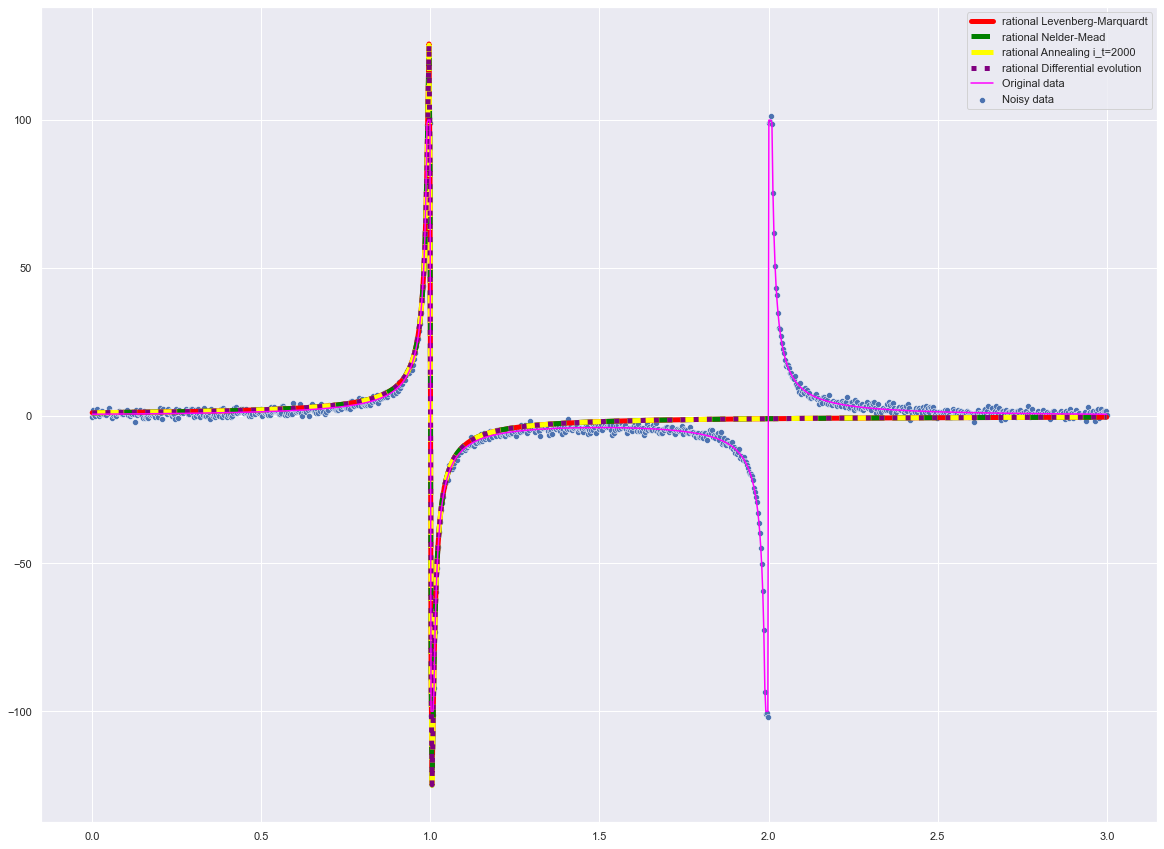

In [54]:
sns.scatterplot(y=yk,x=x,label="Noisy data")

#'-', '--', '-.', ':', 'None', ' ', '', 'solid', 'dashed', 'dashdot', 'dotted'
sns.lineplot(y=rational(x,*rationalLevenbergMarquardt.x),x=x,dashes=[(10,5)], color="red",lw=5,label="rational Levenberg-Marquardt")
sns.lineplot(y=rational(x,*rationalNelderMead.x),x=x,ls="dashed", color="green",lw=5,label="rational Nelder-Mead")
sns.lineplot(y=rational(x,*rationalAnnealing2000.x),x=x,ls="dashdot", color="yellow",lw=5,label="rational Annealing i_t=2000")
sns.lineplot(y=rational(x,*rationalDE.x),x=x,ls="dotted", color="purple",lw=5,label="rational Differential evolution")
#sns.lineplot(y=rational(x,*rationalAnnealing6000.x),x=x,ls="dotted", color="purple",lw=5,label="rational Annealing i_t=6000")

sns.lineplot(y=yk_original,x=x,color="fuchsia",label="Original data")

In [66]:
#128 cities
df=pd.read_csv("https://people.sc.fsu.edu/~jburkardt/datasets/cities/sgb128_xy.txt",sep="\s+",skiprows=7,names=["1","2"])
df

,1,2
0,-5572.57,2839.81
1,-6729.21,2962.82
2,-8326.72,3219.84
3,-4961.07,2920.67
4,-6202.70,3014.64
...,...,...
123,-8278.33,2730.66
124,-7230.86,3483.78
125,-8446.23,2776.26
126,-5246.43,2786.63


In [60]:
data = np.array(df, dtype=float)
dist_matrix = spatial.distance.squareform(spatial.distance.pdist(df))
dist_matrix

array([[   0.        , 1163.16273569, 2780.24549697, ..., 2874.36260727,
         330.4472908 ,   40.95082539],
       [1163.16273569,    0.        , 1618.05360866, ..., 1727.12544825,
        1493.21111853, 1122.21232822],
       [2780.24549697, 1618.05360866,    0.        , ...,  459.39727524,
        3110.60402305, 2739.32101122],
       ...,
       [2874.36260727, 1727.12544825,  459.39727524, ...,    0.        ,
        3199.81680365, 2833.72881843],
       [ 330.4472908 , 1493.21111853, 3110.60402305, ..., 3199.81680365,
           0.        ,  371.33228152],
       [  40.95082539, 1122.21232822, 2739.32101122, ..., 2833.72881843,
         371.33228152,    0.        ]])

[100 121  89  25 112  32  49  12  40  51  91  75  87 122  11 102  30  58
  60  76  55  48  88  77   2  83 119  66  78  74   0  70  81  21  36  41
  20  72 120  96  69   4   8  16  79 113  43 124  84  33  10 111  85  13
  97  98  71 115 125  14  38  80  19  93 127  56  27  94  54  67 126  37
  99 103  22  39  90 107  23   5   7  64  35   6 105  29  45  63  82  95
  31  15  61  57  42 109  50  53 110 123  62  24  18  34  26  59  86  92
  28   1  52   9 114  73  68   3 106 117  44  65  47 116 108  17 101 118
  46 104]


[Text(0.5, 0, 'x'), Text(0, 0.5, 'y')]

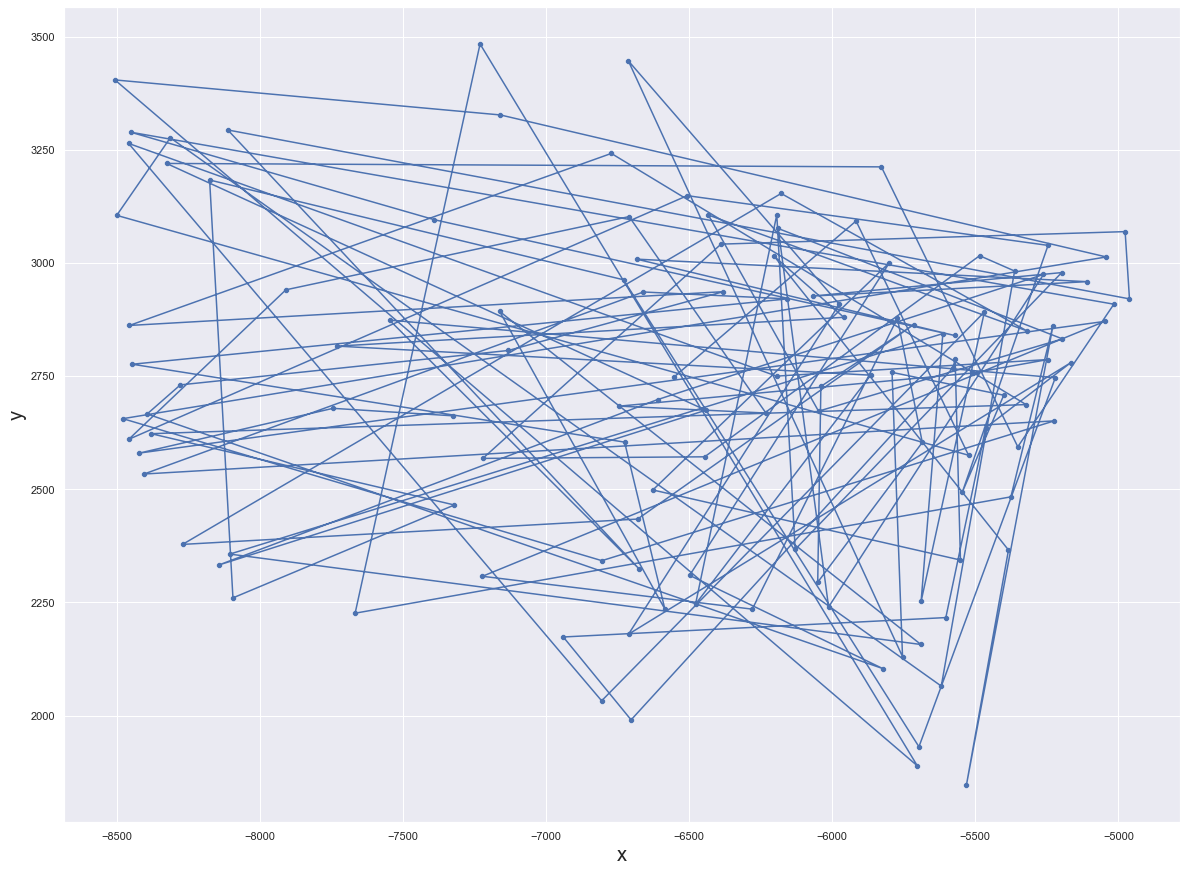

In [87]:
#initial guess
#generate range with all vertices and shuffle it to get some path
random_start=np.array(range(len(df)))

np.random.seed(235151)
np.random.shuffle(random_start)
print(random_start)

ax=sns.scatterplot(x=df.iloc[random_start,0],y=df.iloc[random_start,1])
plt.plot(df.iloc[random_start,0],df.iloc[random_start,1])
ax.set(xlabel='x', ylabel='y')

In [91]:
#from https://pypi.org/project/frigidum/
local_opt = frigidum.sa(random_start=lambda :random_start,
           objective_function=tsp.objective_function,
           neighbours=[tsp.euclidian_bomb_and_fix, tsp.euclidian_nuke_and_fix, tsp.route_bomb_and_fix, tsp.route_nuke_and_fix, tsp.random_disconnect_vertices_and_fix],
           copy_state=frigidum.annealing.naked,
           T_start=100000,
           T_stop=0.001,
           repeats=10**2,
           post_annealing = tsp.local_search_2opt)
local_opt

T: 0.001, M: 0.00, O_min: 15430.6704, O_current: 15430.6704: 100%|██████████| 175/175 [02:08<00:00,  1.36cooling/s]


---
Neighbour Statistics: 
(proportion of proposals which got accepted *and* changed the objective function)
   euclidian_bomb_and_fix           : 0.261835
   euclidian_nuke_and_fix           : 0.279284
   route_bomb_and_fix               : 0.269669
   route_nuke_and_fix               : 0.280420
   random_disconnect_vertices_and_  : 0.154682
---
(Local) Minimum Objective Value Found: 
   15430.67042078


(array([122, 110, 109, 121, 120, 119, 108, 107, 118, 117, 106, 105, 104,
        116, 127, 115, 103, 114, 126, 125, 113, 102, 101,  65,  33,   0,
          1,  34,  66,  67,  68,  36,  35,   2,   3,   4,   5,  38,  37,
         69,  70,  71,  72,  73,  41,  40,  39,   6,   7,   8,   9,  42,
         74,  75,  43,  10,  11,  44,  76,  98,  77,  45,  12,  13,  46,
         78,  79,  99,  80,  48,  47,  14,  15,  16,  17,  50,  49,  81,
         82,  83,  84,  52,  51,  18,  19,  20,  53,  85,  86,  54,  21,
         22,  55,  87,  88,  89,  57,  56,  23,  24,  25,  26,  27,  28,
         61,  60,  59,  58,  90,  91, 100,  92,  93,  94,  62,  29,  30,
         31,  32,  64,  63,  95,  96,  97, 112, 124, 123, 111]),
 15430.670420780054)

[Text(0.5, 0, 'x'), Text(0, 0.5, 'y')]

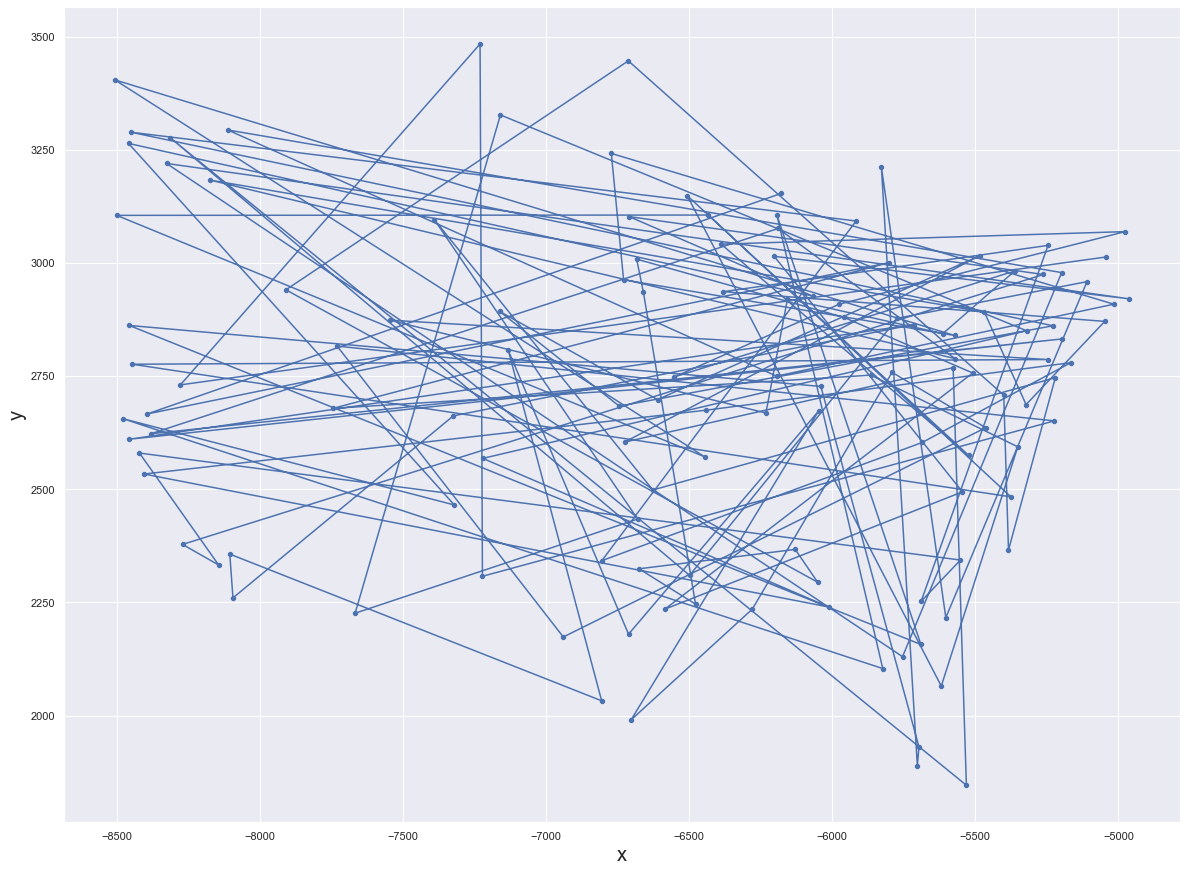

In [93]:
ax=sns.scatterplot(x=df.iloc[local_opt[0],0],y=df.iloc[local_opt[0],1])
plt.plot(df.iloc[local_opt[0],0],df.iloc[local_opt[0],1])
ax.set(xlabel='x', ylabel='y')

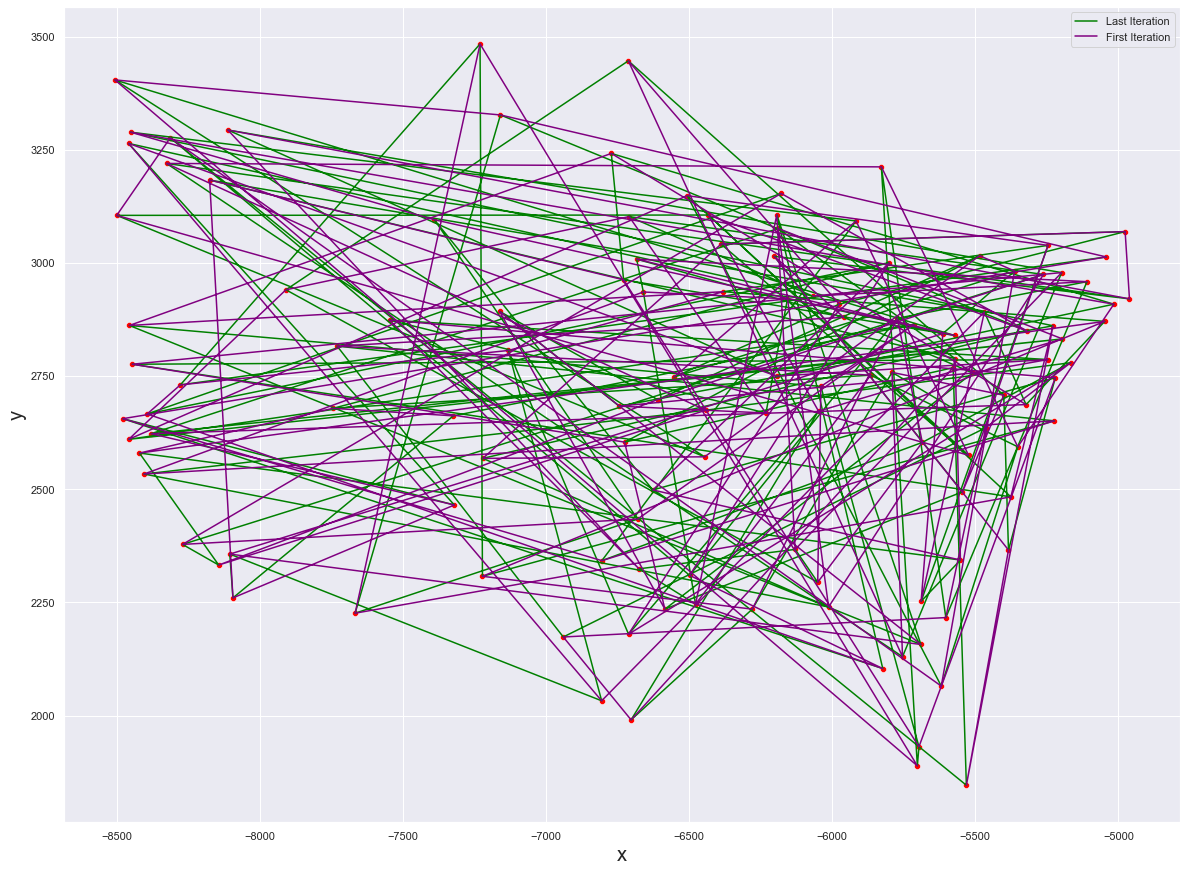

In [108]:
ax=sns.scatterplot(x=df.iloc[local_opt[0],0],y=df.iloc[local_opt[0],1],color="red")
plt.plot(df.iloc[local_opt[0],0],df.iloc[local_opt[0],1],color="green",label="Last Iteration")
plt.plot(df.iloc[random_start,0],df.iloc[random_start,1],color="purple",label="First Iteration")
ax.set(xlabel='x', ylabel='y')
ax.legend()